In [1]:
pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/tongpython/cat-and-dog")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tunahanfaruk
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog


100%|██████████| 218M/218M [00:00<00:00, 611MB/s]


In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])


val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
train_dir = os.path.join('/content/cat-and-dog/training_set/training_set')
val_dir = os.path.join('/content/val')
test_dir = os.path.join('/content/cat-and-dog/test_set/test_set')

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

In [11]:
batch_size = 64

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size ,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=4)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


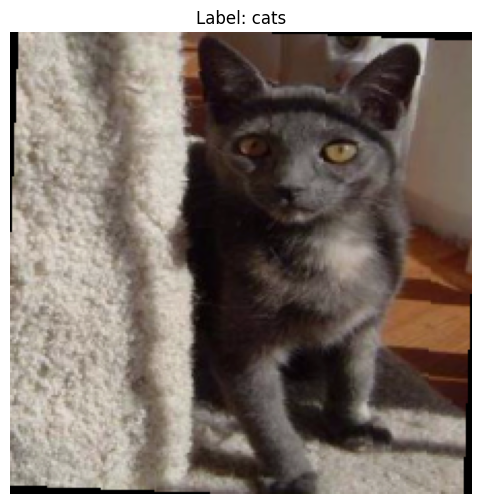

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import random


index = random.randint(0, len(train_dataset) - 1)
image, label = train_dataset[index]


image = image.numpy().transpose((1, 2, 0))  
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean
image = np.clip(image, 0, 1)

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Label: {train_dataset.classes[label]}")
plt.axis('off')
plt.show()

In [21]:
model = nn.Sequential(
    nn.AdaptiveAvgPool2d((224, 224)),

    
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1)
)









In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [23]:
summary(model, input_size=(3,224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 AdaptiveAvgPool2d-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 64, 224, 224]           1,792
       BatchNorm2d-3         [-1, 64, 224, 224]             128
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
       BatchNorm2d-7        [-1, 128, 112, 112]             256
              ReLU-8        [-1, 128, 112, 112]               0
         MaxPool2d-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 256, 56, 56]         295,168
      BatchNorm2d-11          [-1, 256, 56, 56]             512
             ReLU-12          [-1, 256, 56, 56]               0
        MaxPool2d-13          [-1, 256, 28, 28]               0
           Conv2d-14          [-1, 512,

In [24]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
import torch
from tqdm import tqdm

def train_model(model, criterion, optimizer, num_epochs=10):
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)


        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device).float()


                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                running_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs).squeeze() > 0.5
                running_corrects += torch.sum(preds == labels.byte())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')

        print()

    print(f'Best val Acc: {best_val_accuracy:.4f}')


    torch.save(model.state_dict(), 'last_model.pth')

    return model




def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            preds = torch.sigmoid(outputs).squeeze() > 0.5
            correct += (preds == labels.byte()).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy


In [26]:
num_epochs = 60
trained_model = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/60
----------


train: 100%|██████████| 126/126 [01:20<00:00,  1.56it/s]


train Loss: 2.6894 Acc: 0.5068


val: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]


val Loss: 0.7012 Acc: 0.5420

Epoch 2/60
----------


train: 100%|██████████| 126/126 [01:20<00:00,  1.56it/s]


train Loss: 0.7273 Acc: 0.5290


val: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]


val Loss: 0.6772 Acc: 0.5570

Epoch 3/60
----------


train: 100%|██████████| 126/126 [01:21<00:00,  1.56it/s]


train Loss: 0.6853 Acc: 0.5530


val: 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]


val Loss: 0.6724 Acc: 0.5650

Epoch 4/60
----------


train: 100%|██████████| 126/126 [01:20<00:00,  1.56it/s]


train Loss: 0.6779 Acc: 0.5587


val: 100%|██████████| 16/16 [00:04<00:00,  3.77it/s]


val Loss: 0.6660 Acc: 0.5670

Epoch 5/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]


train Loss: 0.6669 Acc: 0.5828


val: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]


val Loss: 0.6438 Acc: 0.6430

Epoch 6/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]


train Loss: 0.6559 Acc: 0.6034


val: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


val Loss: 0.6430 Acc: 0.6570

Epoch 7/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]


train Loss: 0.6453 Acc: 0.6186


val: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]


val Loss: 0.5862 Acc: 0.6850

Epoch 8/60
----------


train: 100%|██████████| 126/126 [01:21<00:00,  1.55it/s]


train Loss: 0.6367 Acc: 0.6325


val: 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]


val Loss: 0.5791 Acc: 0.7030

Epoch 9/60
----------


train: 100%|██████████| 126/126 [01:20<00:00,  1.56it/s]


train Loss: 0.6153 Acc: 0.6586


val: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]


val Loss: 0.5584 Acc: 0.7140

Epoch 10/60
----------


train: 100%|██████████| 126/126 [01:20<00:00,  1.56it/s]


train Loss: 0.5972 Acc: 0.6843


val: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


val Loss: 1.1378 Acc: 0.5680

Epoch 11/60
----------


train: 100%|██████████| 126/126 [01:21<00:00,  1.55it/s]


train Loss: 0.6222 Acc: 0.6496


val: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]


val Loss: 0.5351 Acc: 0.7200

Epoch 12/60
----------


train: 100%|██████████| 126/126 [01:20<00:00,  1.56it/s]


train Loss: 0.5714 Acc: 0.7031


val: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]


val Loss: 0.5052 Acc: 0.7440

Epoch 13/60
----------


train: 100%|██████████| 126/126 [01:20<00:00,  1.57it/s]


train Loss: 0.5656 Acc: 0.7158


val: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]


val Loss: 0.5242 Acc: 0.7360

Epoch 14/60
----------


train: 100%|██████████| 126/126 [01:20<00:00,  1.56it/s]


train Loss: 0.5513 Acc: 0.7279


val: 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]


val Loss: 0.5330 Acc: 0.7350

Epoch 15/60
----------


train: 100%|██████████| 126/126 [01:21<00:00,  1.55it/s]


train Loss: 0.5362 Acc: 0.7358


val: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


val Loss: 0.4762 Acc: 0.7700

Epoch 16/60
----------


train: 100%|██████████| 126/126 [01:22<00:00,  1.54it/s]


train Loss: 0.5377 Acc: 0.7348


val: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]


val Loss: 0.4612 Acc: 0.7790

Epoch 17/60
----------


train: 100%|██████████| 126/126 [01:21<00:00,  1.55it/s]


train Loss: 0.5196 Acc: 0.7458


val: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]


val Loss: 0.4379 Acc: 0.7890

Epoch 18/60
----------


train: 100%|██████████| 126/126 [01:22<00:00,  1.53it/s]


train Loss: 0.4896 Acc: 0.7746


val: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]


val Loss: 0.4679 Acc: 0.7990

Epoch 19/60
----------


train: 100%|██████████| 126/126 [01:21<00:00,  1.55it/s]


train Loss: 0.5048 Acc: 0.7633


val: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


val Loss: 0.4394 Acc: 0.8070

Epoch 20/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]


train Loss: 0.4735 Acc: 0.7800


val: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]


val Loss: 0.4349 Acc: 0.8100

Epoch 21/60
----------


train: 100%|██████████| 126/126 [01:20<00:00,  1.57it/s]


train Loss: 0.4523 Acc: 0.7925


val: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]


val Loss: 0.3894 Acc: 0.8410

Epoch 22/60
----------


train: 100%|██████████| 126/126 [01:20<00:00,  1.56it/s]


train Loss: 0.4398 Acc: 0.8011


val: 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]


val Loss: 0.4376 Acc: 0.8230

Epoch 23/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.60it/s]


train Loss: 0.4154 Acc: 0.8164


val: 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]


val Loss: 0.4226 Acc: 0.8150

Epoch 24/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]


train Loss: 0.3955 Acc: 0.8331


val: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]


val Loss: 0.3744 Acc: 0.8240

Epoch 25/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.60it/s]


train Loss: 0.3720 Acc: 0.8451


val: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


val Loss: 0.3561 Acc: 0.8520

Epoch 26/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.60it/s]


train Loss: 0.3523 Acc: 0.8553


val: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]


val Loss: 0.3256 Acc: 0.8590

Epoch 27/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]


train Loss: 0.3345 Acc: 0.8602


val: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]


val Loss: 0.3832 Acc: 0.8450

Epoch 28/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]


train Loss: 0.3336 Acc: 0.8658


val: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]


val Loss: 0.3497 Acc: 0.8620

Epoch 29/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.60it/s]


train Loss: 0.3091 Acc: 0.8693


val: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]


val Loss: 0.2714 Acc: 0.8950

Epoch 30/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]


train Loss: 0.2969 Acc: 0.8768


val: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


val Loss: 0.3778 Acc: 0.8370

Epoch 31/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]


train Loss: 0.3126 Acc: 0.8738


val: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]


val Loss: 0.3487 Acc: 0.8680

Epoch 32/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]


train Loss: 0.2885 Acc: 0.8833


val: 100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


val Loss: 0.4232 Acc: 0.8330

Epoch 33/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]


train Loss: 0.2616 Acc: 0.8931


val: 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]


val Loss: 0.2666 Acc: 0.9050

Epoch 34/60
----------


train: 100%|██████████| 126/126 [01:17<00:00,  1.62it/s]


train Loss: 0.2648 Acc: 0.8956


val: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.3250 Acc: 0.8840

Epoch 35/60
----------


train: 100%|██████████| 126/126 [01:17<00:00,  1.63it/s]


train Loss: 0.2455 Acc: 0.8969


val: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]


val Loss: 0.2532 Acc: 0.8970

Epoch 36/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]


train Loss: 0.2216 Acc: 0.9157


val: 100%|██████████| 16/16 [00:04<00:00,  3.81it/s]


val Loss: 0.2912 Acc: 0.8830

Epoch 37/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.60it/s]


train Loss: 0.2243 Acc: 0.9136


val: 100%|██████████| 16/16 [00:04<00:00,  3.83it/s]


val Loss: 0.2515 Acc: 0.8940

Epoch 38/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]


train Loss: 0.2166 Acc: 0.9132


val: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


val Loss: 0.2478 Acc: 0.9040

Epoch 39/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]


train Loss: 0.2208 Acc: 0.9086


val: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


val Loss: 0.2625 Acc: 0.9070

Epoch 40/60
----------


train: 100%|██████████| 126/126 [01:20<00:00,  1.57it/s]


train Loss: 0.2187 Acc: 0.9132


val: 100%|██████████| 16/16 [00:04<00:00,  3.83it/s]


val Loss: 0.2481 Acc: 0.9110

Epoch 41/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.60it/s]


train Loss: 0.2664 Acc: 0.8884


val: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]


val Loss: 0.2459 Acc: 0.9030

Epoch 42/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]


train Loss: 0.2101 Acc: 0.9129


val: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


val Loss: 0.2391 Acc: 0.9030

Epoch 43/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]


train Loss: 0.1885 Acc: 0.9210


val: 100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


val Loss: 0.2056 Acc: 0.9290

Epoch 44/60
----------


train: 100%|██████████| 126/126 [01:17<00:00,  1.62it/s]


train Loss: 0.1885 Acc: 0.9255


val: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]


val Loss: 0.2594 Acc: 0.8930

Epoch 45/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]


train Loss: 0.2290 Acc: 0.9062


val: 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


val Loss: 0.1916 Acc: 0.9280

Epoch 46/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]


train Loss: 0.1766 Acc: 0.9282


val: 100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.2443 Acc: 0.8990

Epoch 47/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.60it/s]


train Loss: 0.1621 Acc: 0.9380


val: 100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


val Loss: 0.3201 Acc: 0.8720

Epoch 48/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.60it/s]


train Loss: 0.1616 Acc: 0.9369


val: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


val Loss: 0.1957 Acc: 0.9180

Epoch 49/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.60it/s]


train Loss: 0.1772 Acc: 0.9342


val: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


val Loss: 0.2041 Acc: 0.9280

Epoch 50/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]


train Loss: 0.1562 Acc: 0.9409


val: 100%|██████████| 16/16 [00:04<00:00,  3.91it/s]


val Loss: 0.2838 Acc: 0.8910

Epoch 51/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]


train Loss: 0.1615 Acc: 0.9352


val: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]


val Loss: 0.3017 Acc: 0.8940

Epoch 52/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]


train Loss: 0.1497 Acc: 0.9387


val: 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]


val Loss: 0.2647 Acc: 0.9250

Epoch 53/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]


train Loss: 0.1448 Acc: 0.9442


val: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]


val Loss: 0.2180 Acc: 0.9120

Epoch 54/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]


train Loss: 0.1362 Acc: 0.9483


val: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]


val Loss: 0.2313 Acc: 0.9070

Epoch 55/60
----------


train: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]


train Loss: 0.1406 Acc: 0.9463


val: 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]


val Loss: 0.1986 Acc: 0.9330

Epoch 56/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.60it/s]


train Loss: 0.1318 Acc: 0.9504


val: 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]


val Loss: 0.2242 Acc: 0.9290

Epoch 57/60
----------


train: 100%|██████████| 126/126 [01:17<00:00,  1.62it/s]


train Loss: 0.1296 Acc: 0.9514


val: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]


val Loss: 0.1750 Acc: 0.9350

Epoch 58/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]


train Loss: 0.1259 Acc: 0.9534


val: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]


val Loss: 0.2214 Acc: 0.9290

Epoch 59/60
----------


train: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]


train Loss: 0.1332 Acc: 0.9490


val: 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]


val Loss: 0.1947 Acc: 0.9310

Epoch 60/60
----------


train: 100%|██████████| 126/126 [01:17<00:00,  1.62it/s]


train Loss: 0.1192 Acc: 0.9523


val: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]


val Loss: 0.2823 Acc: 0.9170

Best val Acc: 0.9350


In [27]:
test_accuracy = evaluate_model(trained_model, test_loader)

Testing: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]

Test Accuracy: 0.9277
